## Analysis - Housing Price Prediction using Zillow Data

In [1]:
# Importing what we need 
import numpy as np 
e = np.e
import pandas as pd 
import seaborn as sns
import matplotlib
import statsmodels.api as sm 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import chart_studio.plotly as cspy
import plotly as ply
import cufflinks as cf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mango.tuner import Tuner
import housing_price_pred_functions as myfuncs
import warnings
warnings.filterwarnings('ignore')


# Data Model Implementation

### Data extraction

In [2]:
# Read the data
df = pd.read_csv("../resources/data/metro_zillow.csv", nrows=1000)

# Taking a look at the shape of the dataset
print(df.shape)

# This line will tell us how many of our rows represent metro areas
print(df.RegionType.value_counts())

# Examining the first five rows of our dataframe
df.head()

(928, 87)
RegionType
msa        927
country      1
Name: count, dtype: int64


,RegionID,SizeRank,RegionName,RegionType,StateName,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,...,3/31/2024,4/30/2024,5/31/2024,6/30/2024,7/31/2024,8/31/2024,9/30/2024,10/31/2024,11/30/2024,12/31/2024
0,394327,139,"Anchorage, AK",msa,AK,298332.0,308298.0,316383.0,321350.0,319717.0,...,414483.0,430152.0,438819.0,443502,441333.0,441000.0,438000.0,434667,429817.0,428150.0
1,394580,407,"Fairbanks, AK",msa,AK,221183.0,229100.0,236467.0,245533.0,247200.0,...,324200.0,330933.0,337600.0,345083,343450.0,331783.0,323267.0,321600,328267.0,331600.0
2,394730,802,"Juneau, AK",msa,AK,386817.0,380983.0,378567.0,379317.0,388817.0,...,510833.0,548167.0,555000.0,553333,545833.0,560833.0,560833.0,563333,544167.0,529167.0
3,394743,936,"Ketchikan, AK",msa,AK,324500.0,327833.0,333000.0,344500.0,358167.0,...,441667.0,441000.0,459667.0,455167,462167.0,453833.0,457333.0,453000,452667.0,454500.0
4,394388,51,"Birmingham, AL",msa,AL,209267.0,218967.0,225633.0,229600.0,229900.0,...,276633.0,281709.0,290009.0,296643,299833.0,299533.0,299467.0,296900,293867.0,287157.0


The raw dataframe contains 928 rows and 87 columns. Among these columns, five provide details about the metro area associated with each row. Columns 6 through 82 represent a time series spanning from March 2018 to December 2024, with values indicating the median home price for that metro area in each specific month.

Notably, out of the 928 rows, the last row is unique in that it does not correspond to a specific metro area. Instead, it tracks the median home price for the entire United States.

### Data Cleaning
* For an investment in California, we need to filter down our dataset to metro areas in CA
* So after filtering our dataframe down, we are left with 34 metro areas throughout California.

In [3]:
# Making a dataframe of just California data
df_ca = df[df['StateName'] == 'CA']

# Seeing how many rows we get 
print(df_ca.shape)

# Sanity check 
df_ca.head()

(34, 87)


,RegionID,SizeRank,RegionName,RegionType,StateName,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,...,3/31/2024,4/30/2024,5/31/2024,6/30/2024,7/31/2024,8/31/2024,9/30/2024,10/31/2024,11/30/2024,12/31/2024
61,753899,2,"Los Angeles, CA",msa,CA,778333.0,791667.0,799667.0,806300.0,805967.0,...,1041633.0,1075000.0,1108000.0,1133000,1149333.0,1133000.0,1116333.0,1099967,1091633.0,1067967.0
62,395057,12,"San Francisco, CA",msa,CA,895731.0,946083.0,978000.0,989667.0,972667.0,...,1163333.0,1198000.0,1211333.0,1211000,1194667.0,1166000.0,1163000.0,1166300,1148300.0,1084300.0
63,395025,13,"Riverside, CA",msa,CA,389967.0,394933.0,398267.0,399900.0,399767.0,...,593667.0,597967.0,599633.0,600823,600823.0,600490.0,599300.0,599000,599000.0,599000.0
64,395056,17,"San Diego, CA",msa,CA,702667.0,715000.0,721633.0,727967.0,724633.0,...,955300.0,973817.0,990150.0,997667,991333.0,986667.0,978000.0,967667,955667.0,949000.0
65,395045,26,"Sacramento, CA",msa,CA,442633.0,454300.0,458300.0,461333.0,456333.0,...,621612.0,632696.0,642417.0,649417,649667.0,646300.0,641300.0,634967,628000.0,621333.0


* Checking for NaN values

In [4]:
# Checking our dataframe for NaN values
print(f'There are {df_ca.isna().sum().sum()} NaNs in our original dataframe')

# Backfilling that single NaN
df_ca.fillna(method='bfill', inplace=True)

# Sanity check
print(f'There are {df_ca.isna().sum().sum()} NaNs after using backfill')

There are 8 NaNs in our original dataframe
There are 0 NaNs after using backfill


* Getting a list of the values for the last date in our time series

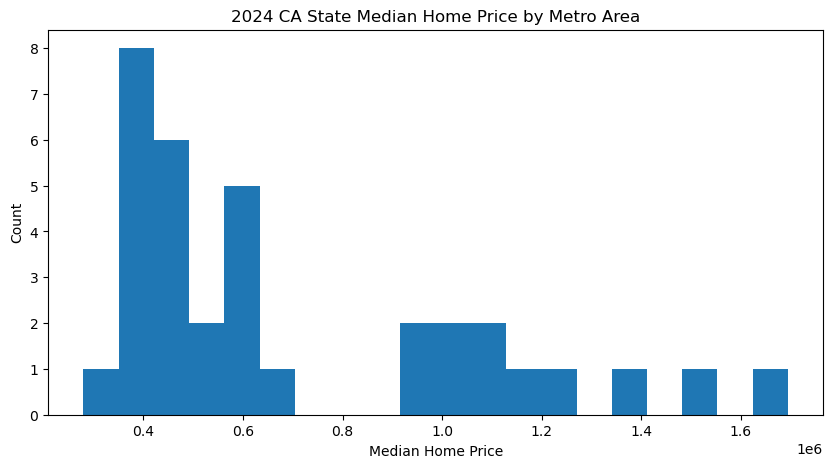

In [5]:
# Getting a list of the values for the last date in our time series
current_median_msa_home_prices = list(df_ca['12/31/2024'])

# Plotting the results
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(current_median_msa_home_prices, bins=20)
plt.title('2024 CA State Median Home Price by Metro Area')
plt.xlabel('Median Home Price')
plt.ylabel('Count')
plt.show()

* We have a few outliers, some of which are Santa Maria and Salinas area, as confirmed below. However, this doesn't necessarily imply that they are the best or worst investment choice, despite what our models may suggest.

In [6]:
# Checking the median home price for Ann Arbor in the most recent month. 
int(df_ca[df_ca['RegionName'] == 'Salinas, CA']['12/31/2024'])

1185750

### Data Transformation
Melting the California dataframe

Text(0, 0.5, 'Averaged Median Home Price')

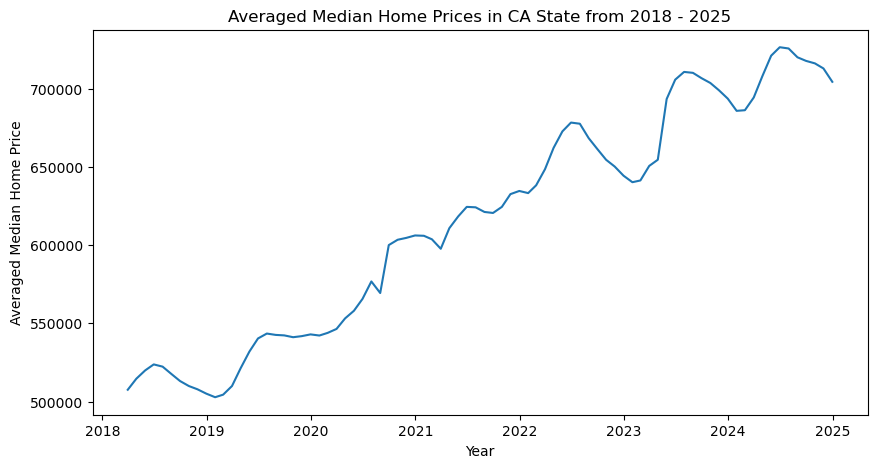

In [7]:
# Melting the California dataframe
df_ca_melted = myfuncs.melt_data(df_ca)

# Plotting the average time series for all of CA state
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df_ca_melted)
plt.title('Averaged Median Home Prices in CA State from 2018 - 2025')
plt.xlabel('Year')
plt.ylabel('Averaged Median Home Price')

Reshaping the Dataframe

In [8]:
# Reshaping the dataframe
df_reshaped = pd.DataFrame()
for i in df_ca['RegionName']:
    x = myfuncs.melt_data(df_ca[df_ca['RegionName'] == i])
    df_reshaped = pd.concat([df_reshaped, x], axis=1)
    df_reshaped.rename(columns = {'value':i}, inplace = True)
    
df_reshaped.head()

,"Los Angeles, CA","San Francisco, CA","Riverside, CA","San Diego, CA","Sacramento, CA","San Jose, CA","Fresno, CA","Bakersfield, CA","Oxnard, CA","Stockton, CA",...,"Hanford, CA","Napa, CA","Eureka, CA","Truckee, CA","Ukiah, CA","Clearlake, CA","Red Bluff, CA","Sonora, CA","Susanville, CA","Crescent City, CA"
time,,,,,,,,,,,,,,,,,,,,,
2018-03-31,778333.0,895731.0,389967.0,702667.0,442633.0,1199456.0,296167.0,256633.0,751450.0,378000.0,...,248217.0,808333.0,395483.0,545667.0,559951.0,299300.0,266617.0,317967.0,236650.0,284917.0
2018-04-30,791667.0,946083.0,394933.0,715000.0,454300.0,1239086.0,297857.0,261800.0,751450.0,378333.0,...,250483.0,842333.0,395483.0,539333.0,548284.0,305000.0,273317.0,329650.0,230667.0,290250.0
2018-05-31,799667.0,978000.0,398267.0,721633.0,458300.0,1269094.0,302823.0,266133.0,751600.0,380000.0,...,252483.0,902333.0,393483.0,531333.0,552303.0,311667.0,279158.0,336317.0,209943.0,293000.0
2018-06-30,806300.0,989667.0,399900.0,727967.0,461333.0,1269613.0,306657.0,267467.0,749433.0,385000.0,...,253567.0,922333.0,394333.0,526667.0,567333.0,325000.0,277492.0,342983.0,206795.0,291167.0
2018-07-31,805967.0,972667.0,399767.0,724633.0,456333.0,1263317.0,309966.0,268667.0,749467.0,390000.0,...,254383.0,913000.0,392000.0,519833.0,583667.0,326000.0,275492.0,344333.0,213461.0,287833.0


Time Series Length
* A key characteristic of our raw dataset must be addressed: Like the rest of the U.S., California experienced a sharp decline in home sales in 2021. If we train our models on the entire dataset, they may be disproportionately influenced pre-2020, sub 3% interest rates, which could impact their predictive accuracy—especially since our business use case focuses on forecasting just one year ahead.
* To prevent this from compromising model performance in validation tests and future predictions, we will limit our training data to only include data from March 2018 onward.

In [9]:
# Reshape to make sure we train our model from Mar 2018 and beyond
df_2018 = df_reshaped['2018-03-31':]

# Examining the new shape
print(df_2018.shape)

# Sanity check
df_2018.head()

(82, 34)


,"Los Angeles, CA","San Francisco, CA","Riverside, CA","San Diego, CA","Sacramento, CA","San Jose, CA","Fresno, CA","Bakersfield, CA","Oxnard, CA","Stockton, CA",...,"Hanford, CA","Napa, CA","Eureka, CA","Truckee, CA","Ukiah, CA","Clearlake, CA","Red Bluff, CA","Sonora, CA","Susanville, CA","Crescent City, CA"
time,,,,,,,,,,,,,,,,,,,,,
2018-03-31,778333.0,895731.0,389967.0,702667.0,442633.0,1199456.0,296167.0,256633.0,751450.0,378000.0,...,248217.0,808333.0,395483.0,545667.0,559951.0,299300.0,266617.0,317967.0,236650.0,284917.0
2018-04-30,791667.0,946083.0,394933.0,715000.0,454300.0,1239086.0,297857.0,261800.0,751450.0,378333.0,...,250483.0,842333.0,395483.0,539333.0,548284.0,305000.0,273317.0,329650.0,230667.0,290250.0
2018-05-31,799667.0,978000.0,398267.0,721633.0,458300.0,1269094.0,302823.0,266133.0,751600.0,380000.0,...,252483.0,902333.0,393483.0,531333.0,552303.0,311667.0,279158.0,336317.0,209943.0,293000.0
2018-06-30,806300.0,989667.0,399900.0,727967.0,461333.0,1269613.0,306657.0,267467.0,749433.0,385000.0,...,253567.0,922333.0,394333.0,526667.0,567333.0,325000.0,277492.0,342983.0,206795.0,291167.0
2018-07-31,805967.0,972667.0,399767.0,724633.0,456333.0,1263317.0,309966.0,268667.0,749467.0,390000.0,...,254383.0,913000.0,392000.0,519833.0,583667.0,326000.0,275492.0,344333.0,213461.0,287833.0


Exporting the reshaped data to CSV

In [10]:
#exporting the cleaned,reshaped dataframe
df_2018.to_csv('../resources/data/df_2018_2023_zillow_data.csv')

Import Cleaned Data & Train/Test Split
* To validate our models and assess their effectiveness, we need to split our time series data into a training set and a test set. In a time series context, the training set will consist of the first 80% of the data, while the test set will cover the remaining 20%. Since our post-March 2018 data spans 6.82 years, this results in a training period of 5.25 years and a test period of 1.58 years.
* This training-to-test ratio strengthens the justification for our predictions. If our models can accurately forecast values 2 years ahead based on 6.82 years of data, we can be more confident in their ability to predict values one year ahead using a larger dataset.

In [11]:
df_cleaned = pd.read_csv('../resources/data/df_2018_2023_zillow_data.csv')  
df_cleaned.set_index('time', inplace=True)
df_cleaned.index = pd.to_datetime(df_cleaned.index)
df_cleaned.head()
# Manually dividing the data into train and test sets
train = df_cleaned.loc['2018-03-31':'2023-05-31'] # 5 years, 2 months for train data
test = df_cleaned.loc['2023-06-01':'2024-12-31'] # 1 year, 6 montsh for test data


In [12]:
# Printing out the lengths of our unsplit time series 
print(f'Whole series lengths: {len(df_cleaned)} \n')

# Printing the lengths of our new train and test sets
print(f'Train set lengths: {len(train)}')
print(f'Test set lengths: {len(test)} \n')

# Checking that the proportions are how we want them 
print(f'Train proportion = {round(len(train) / len(df_cleaned),1)}')
print(f'Test proportion = {round(len(test) / len(df_cleaned),1)} \n')

# Checking the length in years of our train and test sets
print(f'Train set length in years: {round(len(train) / 12, 2)}')
print(f'Test set length in years: {round(len(test) / 12, 2)}')


Whole series lengths: 82 

Train set lengths: 63
Test set lengths: 19 

Train proportion = 0.8
Test proportion = 0.2 

Train set length in years: 5.25
Test set length in years: 1.58


Removing Trends
* In order to prepare data for the ARIMA model, we run the detrend_test to list metro areas w a p-value above .05. 

In [13]:
train_dt, log_diff_list = myfuncs.detrend_test(train)


Number of p-values above alpha of 0.05: 2

Metro Areas with p-values above alpha of 0.05 ['Oxnard, CA', 'Napa, CA']


In [14]:
# Remove  columns with above 0.05 p-value    
train = train.drop(['Oxnard, CA','Napa, CA'], axis=1)
test = test.drop(['Oxnard, CA','Napa, CA'], axis=1)  
print(train)

            Los Angeles, CA  San Francisco, CA  Riverside, CA  San Diego, CA  \
time                                                                           
2018-03-31         778333.0           895731.0       389967.0       702667.0   
2018-04-30         791667.0           946083.0       394933.0       715000.0   
2018-05-31         799667.0           978000.0       398267.0       721633.0   
2018-06-30         806300.0           989667.0       399900.0       727967.0   
2018-07-31         805967.0           972667.0       399767.0       724633.0   
2018-08-31         797967.0           941000.0       399133.0       714333.0   
2018-09-30         791000.0           929333.0       398833.0       703300.0   
2018-10-31         784667.0           924667.0       397333.0       693617.0   
2018-11-30         781333.0           924333.0       396500.0       688700.0   
2018-12-31         776633.0           899667.0       395166.0       685067.0   
2019-01-31         769967.0           88

Initialize and Evaluate Model
* Since our goal is to identify the five most optimal metro areas for investment within California, we need to run time series models for each metro area individually. Given that there are 34 metro areas, doing this manually is impractical, so we are automating the process by writing functions to handle these steps efficiently. 
* An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. A statistical model is autoregressive if it predicts future values based on past values. In this scenario, the ARIMA model seeks to predict home future prices based based on past periods.
* To ensure our future predictions remain reasonably accurate, we will first assess how well our models perform on existing data. The evaluate_models() function will measure the difference between our model predictions for December 2024 and the actual observed values for that month.
* Since the models are trained only on data from 2018 to 2023, their predictions for December 2024 are made without any knowledge of the test data, which spans from 2023 to 2024. This approach helps validate their reliability in forecasting future trends.

In [15]:
# This dataframe will show us how accurate our models are 
eval_df = myfuncs.evaluate_models(train, test)
#eval_df = eval_df.iloc[:-1]
eval_df

,2024 Actual,2024 Predicted,% Error
Fresno,"453,333","453,802",0.10
Crescent City,"452,000","448,395",0.80
Clearlake,"381,150","375,944",1.37
Chico,"417,054","424,806",1.86
Santa Rosa,"963,000","981,123",1.88
Red Bluff,"413,467","404,012",2.29
Ukiah,"624,150","607,157",2.72
Yuba City,"466,315","480,418",3.02
Stockton,"566,667","586,333",3.47
Madera,"499,667","525,016",5.07


In [16]:
# Calculating the average error using the dataframe above 
average_error = str(round(sum([int(i) for i in eval_df['% Error']]) / len(eval_df) , 2)) + '%'

# Printing the result
print(f"On average our model based predictions were {average_error} off from the observed values.")

On average our model based predictions were 10.22% off from the observed values.


* On average, our arima model's predictions were about 9% off from the actual values in our test set. We are satisfied with these validation results, and combined with manual model tuning we have 91% accuracy. 

* Moreover, this 9% average error comes from models trained on 5 years of data to predict two years ahead. In our final recommendations, we will use ten years of training data to predict just one year ahead. This suggests that our future predictions will likely be even more accurate than those in this validation test.

Generate Predictions on a 24 month period

In [ ]:
# Generate Predictions on a 24 month period
model_predictions_2024 = myfuncs.generate_predictions(eval_df, 24)
model_predictions_2024.sort_values(by='ROI',ascending=False, inplace=True)
model_predictions_2024

Los Angeles
San Francisco
Riverside
San Diego
Sacramento
San Jose
Fresno
Bakersfield
Stockton
Modesto
Santa Rosa
Visalia
Vallejo
Santa Maria
Salinas
San Luis Obispo
Merced
Santa Cruz
Chico
Redding
El Centro
Yuba City
Madera
Hanford
Eureka
Truckee


,City,Current Value,Predicted Value,Net Profit,ROI
0,Los Angeles,"981,333","963,791","-17,542",-1%
1,San Francisco,"1,214,667","1,246,982","32,315",2%
2,Riverside,"563,333","645,382","82,049",14%
3,San Diego,"932,633","1,055,391","122,758",13%
4,Sacramento,"620,983","688,242","67,259",10%
5,San Jose,"1,616,000","1,858,365","242,365",15%
6,Fresno,"430,267","453,802","23,535",5%
7,Bakersfield,"379,283","426,434","47,151",12%
8,Stockton,"559,629","586,333","26,704",4%
9,Modesto,"496,665","586,605","89,940",18%


In [18]:
# A list of the top five metro areas output by our arima models
arima_model_top_5 = ['Vallejo, CA', 'Modesto, CA', 'San Jose, CA', 'Riverside, CA','San Diego, CA']

# Variables to track initial and final investment value
buys = 0
sells = 0

# Adding the relevant values
for i in arima_model_top_5:
    buys  += df_cleaned[i]['2022-12-31']
    sells += df_cleaned[i]['2024-12-31']

# Calculating the ROI
arima_model_roi_2023 = round(((sells - buys) / buys) * 100 , 2)

# Displaying the results
print(f'For the top 5 choices and using ARIMA, we could have achieved {arima_model_roi_2023}% ROI from 2022 to 2024')


For the top 5 choices and using ARIMA, we could have achieved 4.62% ROI from 2022 to 2024


## Predictions
* The goal of this project is to give potential clients a starting point for investing in California real estate by identifying the five metro areas best suited for short-term investment. We have now reached the stage where we can make these predictions.

* Using the same modeling process as before, we will apply our models to the full 2018–2024 dataset to forecast the median home value for each of the 34 metro areas in December 2025. We will then rank these 25 growth estimates by highest projected ROI and select the top five as our final recommendations.

In [20]:
# Generating ARIMA predictions one year past our entire 2018 to 2024 dataset
arima_recommendation_df = myfuncs.generate_predictions(df_cleaned, 12)
arima_recommendation_df.sort_values(by='ROI',ascending=False, inplace=True)
arima_recommendation_df

Los Angeles
San Francisco
Riverside
San Diego
Sacramento
San Jose
Fresno
Bakersfield
Oxnard
Stockton
Modesto
Santa Rosa
Visalia
Vallejo
Santa Maria
Salinas
San Luis Obispo
Merced
Santa Cruz
Chico
Redding
El Centro
Yuba City
Madera
Hanford
Napa


,City,Current Value,Predicted Value,Net Profit,ROI
17,Merced,"449,650","481,102","31,452",6%
10,Modesto,"508,316","536,360","28,044",5%
18,Santa Cruz,"1,263,000","1,317,194","54,194",4%
4,Sacramento,"621,333","651,005","29,672",4%
7,Bakersfield,"383,300","402,324","19,024",4%
8,Oxnard,"992,000","1,025,839","33,839",3%
22,Yuba City,"466,315","477,010","10,695",2%
16,San Luis Obispo,"1,023,817","1,054,121","30,304",2%
12,Visalia,"394,633","405,655","11,022",2%
13,Vallejo,"596,000","609,522","13,522",2%


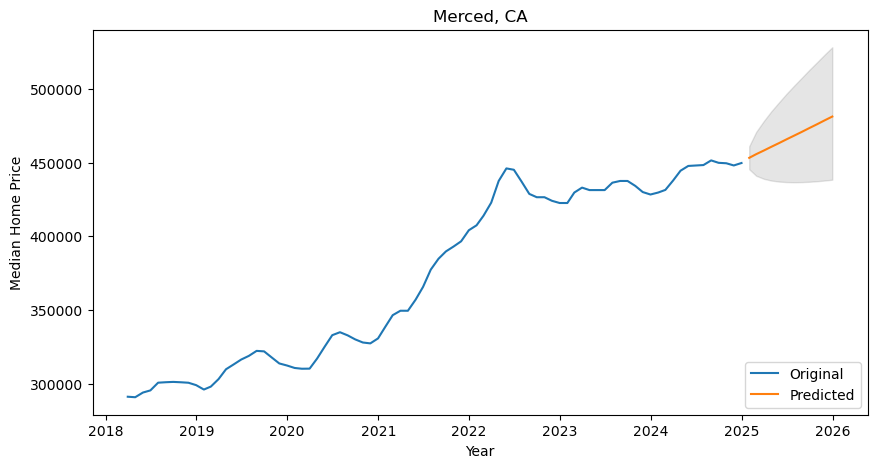

12 month forecast: 481102
95% confidence that the true future value is between 438350, and 528024


In [21]:
myfuncs.plot_results(17, 12, df_cleaned)

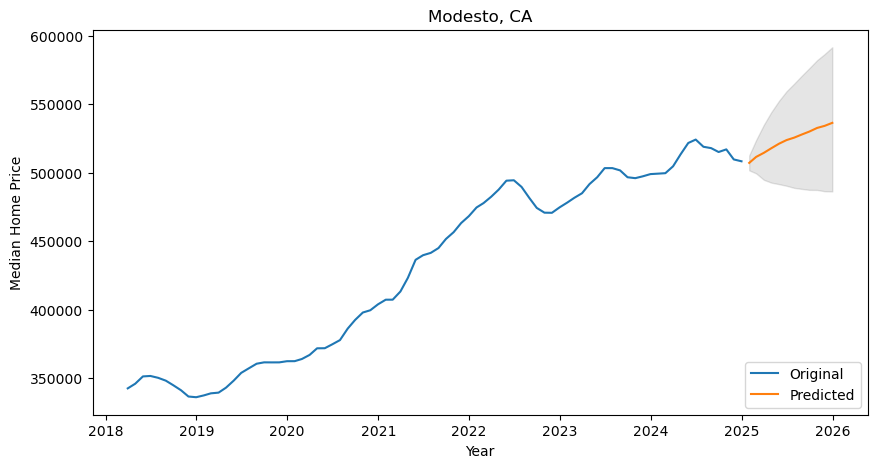

12 month forecast: 536360
95% confidence that the true future value is between 486320, and 591549


In [22]:
myfuncs.plot_results(10, 12, df_cleaned)

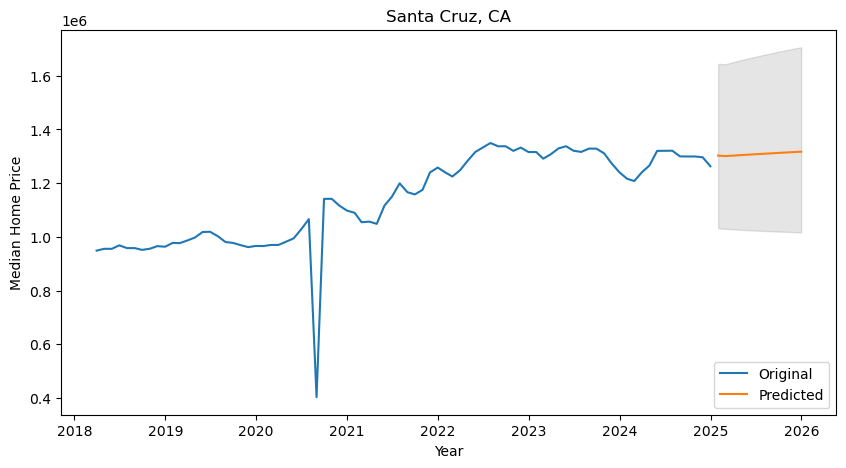

12 month forecast: 1317194
95% confidence that the true future value is between 1016791, and 1706348


In [23]:
myfuncs.plot_results(18, 12, df_cleaned)

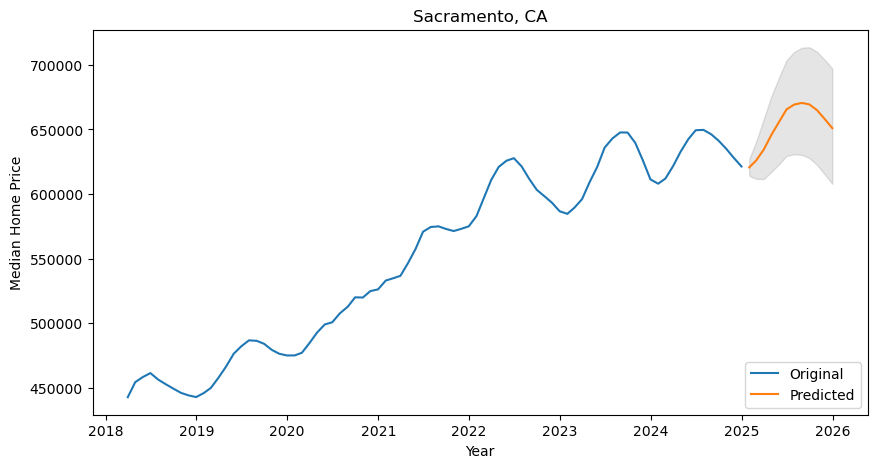

12 month forecast: 651005
95% confidence that the true future value is between 607901, and 697164


In [24]:
myfuncs.plot_results(4, 12, df_cleaned)

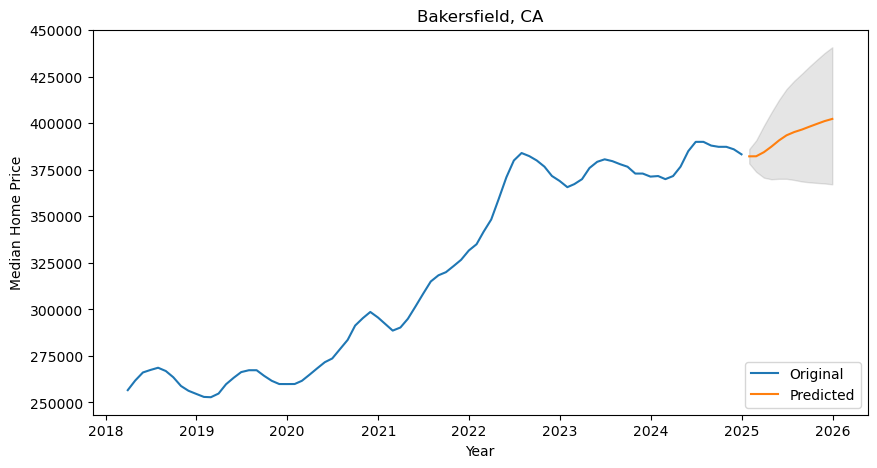

12 month forecast: 402324
95% confidence that the true future value is between 367181, and 440829


In [25]:
myfuncs.plot_results(7, 12, df_cleaned)

# Data Model Optimization

* ARIMA Model Performance

In [26]:
import warnings
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error 

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
myfuncs.evaluate_for_perf_models(df_cleaned['Merced, CA'], p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=77082.425
ARIMA(0, 0, 1) RMSE=39108.126
ARIMA(0, 0, 2) RMSE=23543.552
ARIMA(0, 1, 0) RMSE=3002.889
ARIMA(0, 1, 1) RMSE=3795.657
ARIMA(0, 1, 2) RMSE=2972.305
ARIMA(0, 2, 0) RMSE=3254.428
ARIMA(0, 2, 1) RMSE=3252.892
ARIMA(0, 2, 2) RMSE=3261.778
ARIMA(1, 0, 0) RMSE=3052.797
ARIMA(1, 0, 1) RMSE=2767.805
ARIMA(1, 0, 2) RMSE=2432.907
ARIMA(1, 1, 0) RMSE=2979.649
ARIMA(1, 1, 1) RMSE=3183.208
ARIMA(1, 1, 2) RMSE=3251.832
ARIMA(1, 2, 0) RMSE=3253.021
ARIMA(1, 2, 1) RMSE=3235.136
ARIMA(1, 2, 2) RMSE=3260.799
ARIMA(2, 0, 0) RMSE=3035.145
ARIMA(2, 0, 1) RMSE=2964.674
ARIMA(2, 0, 2) RMSE=2690.829
ARIMA(2, 1, 0) RMSE=2971.632
ARIMA(2, 1, 1) RMSE=3249.959
ARIMA(2, 1, 2) RMSE=3352.368
ARIMA(2, 2, 0) RMSE=3262.085
ARIMA(2, 2, 1) RMSE=3258.537
ARIMA(2, 2, 2) RMSE=3398.112
ARIMA(4, 0, 0) RMSE=2960.578
ARIMA(4, 0, 1) RMSE=2984.505
ARIMA(4, 0, 2) RMSE=2742.246
ARIMA(4, 1, 0) RMSE=2980.985
ARIMA(4, 1, 1) RMSE=2929.073
ARIMA(4, 1, 2) RMSE=3147.916
ARIMA(4, 2, 0) RMSE=3248.344
ARIMA(4, 2,

In [27]:
# Evaluate the model
arima_recommendation_df['Current Value'] = arima_recommendation_df['Current Value'].replace('[\$,]', '0', regex=True).astype(float)
arima_recommendation_df['Predicted Value'] = arima_recommendation_df['Predicted Value'].replace('[\$,]', '0', regex=True).astype(float)
mse = mean_squared_error(arima_recommendation_df['Current Value'], arima_recommendation_df['Predicted Value'])
mae = mean_absolute_error(arima_recommendation_df['Current Value'], arima_recommendation_df['Predicted Value'])
rmse = np.sqrt(mse)

print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')


MSE: 314029674066565.8, MAE: 3724954.653846154, RMSE: 17720882.429116383
